In [2]:
import pandas as pd
import os
import boto3
import io
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [3]:
bucket_name = "lneg-loka"
s3_key_name = "patient_data_raw/patient_data_raw.csv"
processed_file_name = "patient_data_processed.csv"

In [4]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket_name, Key=s3_key_name)
csv_string = obj['Body'].read().decode('utf-8')
df = pd.read_csv(io.StringIO(csv_string))

In [5]:
df

,patient_id,age,sex,bmi,smoker,diagnosis_code,medication_count,days_hospitalized,readmitted,last_lab_glucose,exercise_frequency,diet_quality,income_bracket,education_level,urban,albumin_globulin_ratio,chronic_obstructive_pulmonary_disease,alanine_aminotransferase
0,P00000,69,Male,25.3,No,D1,1,9,1,100.8,NaN,Average,Middle,Secondary,0,0.8934,B,25.4423
1,P00001,32,Male,27.0,Yes,D4,1,7,0,106.3,High,Good,High,Primary,1,0.7104,C,27.0529
2,P00002,89,Female,30.6,No,D1,2,9,0,138.4,NaN,Good,Middle,Tertiary,1,0.1078,B,30.4405
3,P00003,78,Male,17.8,Yes,D1,4,5,0,81.8,Low,Average,Low,Secondary,1,0.3754,C,17.5797
4,P00004,38,Female,37.7,No,D3,5,6,0,115.2,Low,Poor,Low,Primary,1,0.0994,D,37.7834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,P09995,88,Female,29.9,Yes,D1,8,3,1,104.0,NaN,Poor,Low,Primary,1,0.7400,B,30.0000
9996,P09996,43,Male,32.7,No,D5,2,4,0,69.5,Low,Average,Low,NaN,1,0.3098,C,32.6781
9997,P09997,63,Male,34.1,Yes,D2,4,9,1,78.0,Moderate,Good,High,Primary,1,0.8163,B,34.1534
9998,P09998,63,Female,28.0,No,D5,6,7,1,100.8,NaN,Average,Low,Primary,0,0.0544,A,28.0628


In [ ]:
df['chronic_obstructive_pulmonary_disease'].unique()

In [ ]:
df['chronic_obstructive_pulmonary_disease'].hist()

Check if there are NaN/Missing values. There are, only in 'exercise_frequency' and 'education_level' columns, the rest is clean.

In [ ]:
df.isna().sum()

By plotting class-conditional distribution of 'exercise_frequency', it can be seen that it should have little predictive power for prediction chronic obstructive pulmonary disease - the distribution is virtually equal for all classes.

By plotting class-conditional distribution of 'education_level', it can be seen that it should have little predictive power for prediction chronic obstructive pulmonary disease - the distribution is virtually equal for all classes.

Since the distributions of educational_level and exercise_frequency are virtually class-independent, these features have little discriminative power for predicting chronic obstructive pulmonary disease. Because of this, I decided to discard these features instead of other more complex/data wasteful solutions to deal with missing/NaN values.

<Axes: >

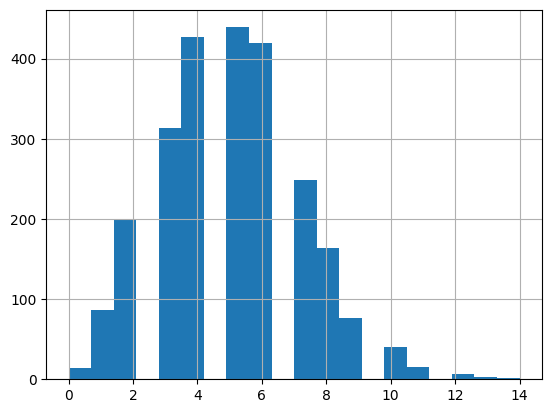

In [27]:
covariate_name = "days_hospitalized"
target="D"
bins_temp = df[df["chronic_obstructive_pulmonary_disease"]==target][covariate_name].unique()
bins = np.array([i for i in bins_temp if str(i).lower() != 'nan'])
bins.sort()
#df[df["chronic_obstructive_pulmonary_disease"]==target][covariate_name].value_counts().loc[bins].plot.bar() #use for categorical variables
df[df["chronic_obstructive_pulmonary_disease"]==target][covariate_name].hist(bins=20) #use for continuous real-valued variables

All variables have equal class-conditional distributions, so it is not possible to get meaningful predictions for chronic obstructive pulmonary disease from these features.
There's almost perfect collinearity between certain features, e.g. BMI and alanine_aminotransferase. Is the data of one of these features corrupted? In any case at least one of these should be dropped

In [ ]:
df_new = df.copy()

Should make preprocessing a part of model pipeline to avoid having to preprocess test data at inference time

Drop problematic/useless/suspicious features

In [ ]:
df_new = df_new.drop('exercise_frequency',axis=1)
df_new = df_new.drop('education_level',axis=1)
df_new = df_new.drop('patient_id',axis=1)
df_new = df_new.drop("alanine_aminotransferase",axis=1)

In [ ]:
df_new

Transform categorical features whose values have a natural ordering

In [ ]:
label_encoder = LabelEncoder()
df_new['diet_quality'] = label_encoder.fit_transform(df['diet_quality'])
df_new['income_bracket'] = label_encoder.fit_transform(df['income_bracket'])

Transform multinomial categorical features whose values don't have natural ordering

In [ ]:
multinomial_categories = ['diagnosis_code']
multinomial_df = pd.get_dummies(df_new[multinomial_categories],drop_first=False)
df_new = df_new.drop(multinomial_categories,axis=1)
df_new = pd.concat([df_new,multinomial_df],axis=1)

Transform binomial categorical features whose values don't have natural ordering

In [ ]:
binomial_categories =['sex','smoker']
binomial_df = pd.get_dummies(df_new[binomial_categories],drop_first=True)
df_new = df_new.drop(binomial_categories,axis=1)
df_new = pd.concat([df_new,binomial_df],axis=1)


Upload cleaned & transformed data to S3

In [ ]:
buffer = io.StringIO()
df_new.to_csv(buffer)
s3.put_object(Bucket = bucket_name, Key = processed_file_name, Body = buffer.getvalue())